In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.signal import detrend, butter, filtfilt, savgol_filter, find_peaks
from scipy.spatial import distance


Importing CSV files

In [56]:
def extract_float_from_string(s):
    # Define a regex pattern to match floats (including negative numbers and decimals)
    float_pattern = r'-?\d+\.?\d*'
    
    # Search for the first occurrence of the pattern in the string
    try:
        match = re.search(float_pattern, s)
        return float(match.group())
    except:
        # If no match is found, return nan
        return float('nan')

# df = pd.read_csv('output.csv', index_col=0)
# df = df.applymap(extract_float_from_string)

df = pd.read_csv("OAW01-OpenPose-bottom-back-2.csv")



In [57]:
df

,time,Nose_x,Nose_y,Nose_conf,LEye_x,LEye_y,LEye_conf,REye_x,REye_y,REye_conf,...,LKnee_conf,RKnee_x,RKnee_y,RKnee_conf,LAnkle_x,LAnkle_y,LAnkle_conf,RAnkle_x,RAnkle_y,RAnkle_conf
0,0.619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.81279,655.385,1063.970,0.83435,597.552,1320.480,0.82916,660.497,1278.390,0.79013
1,0.660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.82389,665.660,1063.770,0.81839,597.547,1320.330,0.81790,660.470,1268.050,0.79221
2,0.701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.79519,665.724,1032.360,0.82076,597.515,1320.630,0.81847,655.220,1231.150,0.82070
3,0.742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.77966,665.720,1032.440,0.81625,597.579,1320.470,0.83857,650.158,1194.590,0.86967
4,0.784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.78214,665.625,1027.240,0.80481,597.588,1320.410,0.83699,649.843,1152.890,0.84374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,10.845,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.91562,560.667,435.330,0.88866,529.587,482.280,0.80181,560.813,482.182,0.80354
249,10.887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.89119,560.692,434.943,0.85856,524.492,477.076,0.82693,555.819,477.103,0.78663
250,10.928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.89158,560.642,434.944,0.85040,524.552,477.032,0.81564,555.732,477.006,0.77758
251,10.969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.87110,560.634,430.001,0.83853,524.588,476.843,0.74445,560.660,476.912,0.75460


In [58]:
fs = 1/np.mean(np.diff(df.time))
fs

# direction of the walk 
direction = "back"

Smooth using a moving average or using a Savitzky-Golay filter 


In [59]:
def smoothing(data, filter):
    window = 5

    if filter == "average": 
        smooth = data.rolling(window=window).mean()
        smooth = smooth.fillna(data).tolist()
    elif filter == "savgol":
        order = 2
        smooth = savgol_filter(data, window, order, deriv=1, delta=df.time[1]-df.time[0])

    return smooth

Butterworth filter


In [60]:
def butterworth_filter(data):
    # fs = 30  # Sampling frequency in Hz
    cutoff = 4  # Cutoff frequency in Hz
    order = 2  
    btype = "lowpass" 

    b, a = butter(order, cutoff / (0.5 * fs), btype=btype)
    buttered = filtfilt(b, a, data)

    return buttered

Full Preprocessing 

In [61]:
def preprocessing(data, filter):
    preprocessed = smoothing(data, filter=filter)
    preprocessed = butterworth_filter(preprocessed)

    return preprocessed

In [62]:
RAnkle = preprocessing(df.LAnkle_y, filter="average")
LAnkle = preprocessing(df.LAnkle_y, filter="average")

In [63]:
def detect_steps(data, direction=''):
    """
    data: time series of the y-pixel of the ankle
    direction: front or back

    returns:
        heel_strikes: the indexes of when the heel first touches the ground 
    """

    dist = 20 # minimum distance between two detected steps taken on a single leg

    if not direction:
        direction = input("Choose walk direction: 'front' or 'back'?")

    # find peaks in the derivative of the y-coord of the ankle
    deriv  = np.gradient(data)
    if direction == 'front':
        peaks, _ = find_peaks(deriv, distance=dist)
    elif direction == 'back':
        peaks, _ = find_peaks(-deriv, distance=dist)

    # detect heel-strikes and toe-offs
    heel_strikes = []
    toe_offs = []
    for peak in peaks:
        peak_height = deriv[peak]
        heel_threshold = 0.35 * abs(peak_height) # heel strike occurs after each peak of the derivative, once the 35% of peak height is crossed
        toe_threshold = 0.3 * abs(peak_height) # toe-off occurs before each peak of the derivative, once the 30% of peak height is crossed

        # heel strikes
        for i in range(peak + 1, len(deriv)):
            if abs(deriv[i]) <= heel_threshold:
                heel_strikes.append(i)
                break
            
        # toe-offs
        for i in range(peak - 1, -1, -1):
            if abs(deriv[i]) <= toe_threshold:
                toe_offs.append(i)
                break

    return heel_strikes, toe_offs

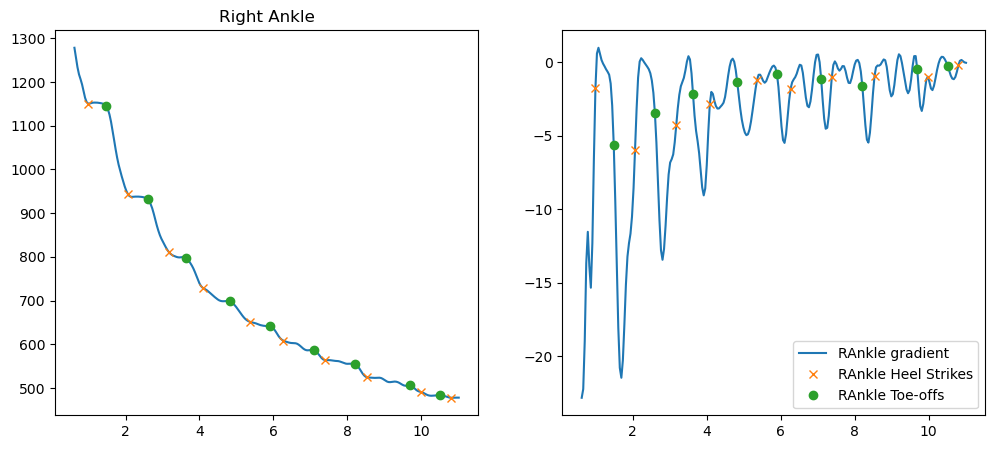

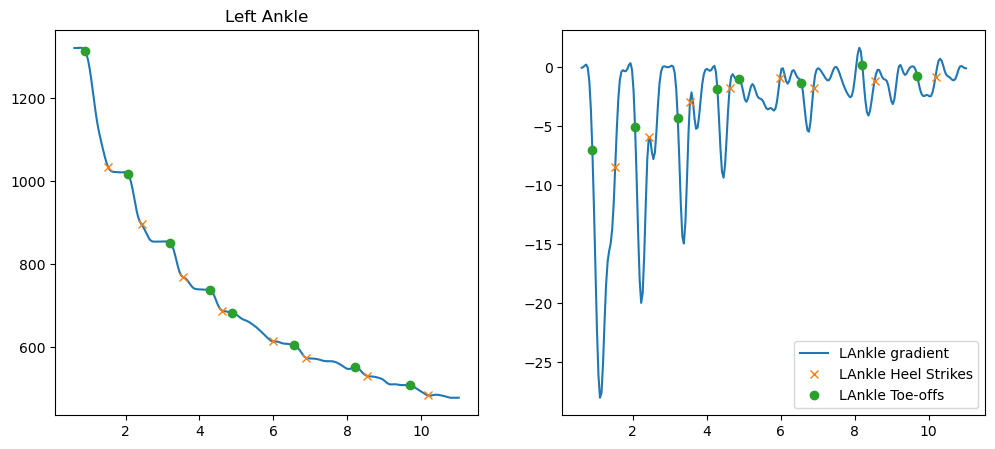

In [64]:
# remove any linear trends
# Rdetrended = detrend(preprocessing(df.RAnkle_y, filter="average"))
# Ldetrended = detrend(preprocessing(df.LAnkle_y, filter="average"))

RAnkle = preprocessing(df.RAnkle_y, filter="average")
LAnkle = preprocessing(df.LAnkle_y, filter="average")

# find steps
RHeels, RToes = detect_steps(RAnkle, direction="back")
LHeels, LToes = detect_steps(LAnkle, direction="back")

# plotting 
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(df.time, RAnkle)
plt.plot(df.time[RHeels], RAnkle[RHeels], "x")
plt.plot(df.time[RToes], RAnkle[RToes], "o", label='RAnkle Toe-offs')
plt.title('Right Ankle')
plt.subplot(1,2,2)
plt.plot(df.time, np.gradient(RAnkle), label="RAnkle gradient")
plt.plot(df.time[RHeels], np.gradient(RAnkle)[RHeels], "x", label='RAnkle Heel Strikes')
plt.plot(df.time[RToes], np.gradient(RAnkle)[RToes], "o", label='RAnkle Toe-offs')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.plot(df.time, LAnkle)
plt.plot(df.time[LHeels], LAnkle[LHeels], "x")
plt.plot(df.time[LToes], LAnkle[LToes], "o", label='LAnkle Toe-offs')
plt.title('Left Ankle')
plt.subplot(1,2,2)
plt.plot(df.time, np.gradient(LAnkle), label="LAnkle gradient")
plt.plot(df.time[LHeels], np.gradient(LAnkle)[LHeels], "x", label='LAnkle Heel Strikes')
plt.plot(df.time[LToes], np.gradient(LAnkle)[LToes], "o", label='LAnkle Toe-offs')
plt.legend(loc="lower right")
plt.show()



In [65]:
# data = preprocessing(df.RAnkle_y, filter="average")
# derivPeaks = detect_steps(data)
# plt.figure()
# plt.plot(df.time, data)
# plt.plot(df.time[derivPeaks], data[derivPeaks], "x", label='RAnkle peaks')
# plt.title('Right ankle vertical coordinate')

# plt.figure()
# plt.plot(df.time, np.gradient(data))
# plt.plot(df.time[derivPeaks], np.gradient(data)[derivPeaks], "x", label='RAnkle peaks')
# plt.title('Derivative of vertical coordinate of the right ankle')
# plt.show()

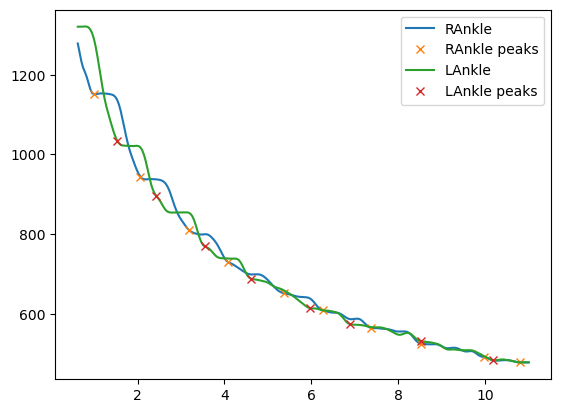

In [66]:
plt.figure()
plt.plot(df.time, RAnkle, label="RAnkle")
plt.plot(df.time[RHeels], RAnkle[RHeels], "x", label='RAnkle peaks')
plt.plot(df.time, LAnkle, label='LAnkle')
plt.plot(df.time[LHeels], LAnkle[LHeels], "x", label='LAnkle peaks')
plt.legend(loc="upper right")
plt.show()

#### Finding Cadence

In [67]:
# index of both right and left steps
steps = LHeels + RHeels
steps.sort()

# A list of how long each step took
steptime = df.time[steps].diff().tolist()[1:-1]

mean_steptime = np.mean(steptime)
std_steptime = np.std(steptime)

cadence = 60/mean_steptime
CV_steptime = std_steptime/mean_steptime # coefficient of variance


#### Finding the average step width
This is calculated by finding the euclidean distance between the ankle joints for each frame, then dividing it by the euclidean distance of the two hip keypoints 

In [68]:
def get_step_width_distances(row):
    ankles = distance.euclidean(row[["RAnkle_x", "RAnkle_y"]], row[["LAnkle_x", "LAnkle_y"]])
    hips = distance.euclidean(row[["LHip_x", "LHip_y"]], row[["RHip_x", "RHip_y"]])

    return pd.Series([ankles, hips])

df[['ankle_distances', 'hip_distances']] = df.apply(get_step_width_distances, axis=1)

average_step_width = (df['ankle_distances'] / df['hip_distances']).mean()
average_step_width

0.8257211150819471

#### Finding the symmetry index (SI) of step times
This is found by finding how long is spent standing on each foot (from the moment of heel-strike until toe-off), taking the absolute value of the difference between the two feet, then dividing by half the total time

If the amount of steps taken on each foot is not equal, some steps will be omitted (at random)

In [69]:
def standing_time(times, heel_strikes, toe_offs):
    """
    This function calculates how much time was spent stood on the floor per step taken in a walk
    """
    
    standing_times = []

    for i in range(0, min([len(heel_strikes), len(toe_offs)])): # the min() helps check how many whole steps are recorded, some have half steps in the beginning/end of the recording
        # in terms of time stamps:
        heel_strike = times[heel_strikes[i]]
        try:
            indx = next(x for x in toe_offs if x > heel_strikes[i])
            toe_off = times[indx]
        except StopIteration:
            break 

        standing_times.append(toe_off - heel_strike)

    return standing_times

In [70]:
RStandingTimes = standing_time(df.time, RHeels, RToes)
LStandingTimes = standing_time(df.time, LHeels, LToes)

length = min([len(LHeels), len(LToes), len(RHeels), len(RToes)])

# Symmetry index calculated by finding the difference between the average standing time on each leg
avgSI = abs((np.mean(RStandingTimes) - np.mean(LStandingTimes)) / (np.mean(RStandingTimes) + np.mean(LStandingTimes)))

# Symmetry index calculated as described originally by (Ng et al., 2020)
SI = abs((sum(RStandingTimes[:length]) - sum(LStandingTimes[:length])) / (sum(RStandingTimes[:length]) + sum(LStandingTimes[:length])))


#### Finding margin of stability (MOS)

The following systematic review gives a good overview of how this is calculated: https://doi.org/10.1186%2Fs12891-021-04466-4

In [72]:
# estimated center of mass (eCOM) - the middle point between the two hip keypoints
if direction == "back":
    df["eCOM_x"] = ((df['RHip_x'] - df['LHip_x']) / 2) + df["LHip_x"]
elif direction == "forward":
    df["eCOM_x"] = ((df['LHip_x'] - df['RHip_x']) / 2) + df["RHip_x"]

# Find the hip width in each frame in order to normalise the leg lengths 
df["Hip_width"] = abs(df['LHip_x'] - df['RHip_x'])

# Find leg length in each frame where a heel strike occurs
# Right leg
df_RHeels = df.loc[RHeels]
df_RHeels["LegLen"] = df_RHeels.apply(lambda row: np.sqrt((row['RHip_y'] - row['RAnkle_y'])**2 + (row['RHip_x'] - row['RAnkle_x'])**2) / row['Hip_width'], axis=1)

# Left eg
df_LHeels = df.loc[LHeels]
df_LHeels["LegLen"] = df_LHeels.apply(lambda row: np.sqrt((row['LHip_y'] - row['LAnkle_y'])**2 + (row['LHip_x'] - row['LAnkle_x'])**2) / row['Hip_width'], axis=1)

# Average leg length 
meanLegLen = np.mean(df_RHeels.LegLen.tolist() + df_LHeels.LegLen.tolist())
meanLegLen


# Finding the extrapolated center of mass (XCOM)
omega = np.sqrt(9.81/meanLegLen); # the natural frequency of the pendulum-like leg
vCOM = np.gradient(df.eCOM_x)

XCOM = df.eCOM_x + (vCOM/omega)



# Calculating the estimated margin of stability (eMOS) in the mediolateral direction

# first, finding the x-axis pixel difference from the XCOM to the right and left ankle, normalised by the hip width
if direction == "front":
    df['RMOS0'] =  (-XCOM + df.RAnkle_x)/df.Hip_width; 
    df['LMOS0'] =  (-XCOM + df.LAnkle_x)/df.Hip_width;
elif direction == "back":
    df['RMOS0'] =  (XCOM - df.RAnkle_x)/df.Hip_width; 
    df['LMOS0'] =  (XCOM - df.LAnkle_x)/df.Hip_width;

# as explained in the paper https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8240253/#CR7, the code above is the calcualtion equivalent to the formula
# MOS = -XCOM + BOS
# Where the BOS is the base of support. When walking, the base of support switches from the left to the right and vice versa on each step.
# Hence, the RMOS may only exist from the moment the right heel strikes, until the following left heel strike, and vice versa:

RMOS = []
RMOS_neg = []

# Loop through each full right step for RMOS
for i, HeelLoc in enumerate(RHeels):
    # find at which video frame the next left heel strike is occuring, unless the video ends before the next strike
    try:
        endLoc = LHeels[i] if LHeels[i] > HeelLoc else LHeels[i+1]
    except IndexError:
        endLoc = df.index[-1]

    for j in range(HeelLoc, endLoc):
        RMOS.append(df['RMOS0'][j])
        if df['RMOS0'][j] < 0:
            RMOS_neg.append(df['RMOS0'][j])
        else:
            RMOS_neg.append(np.nan)

LMOS = []
LMOS_neg = []

# Loop through each full right step for RMOS
for i, HeelLoc in enumerate(LHeels):
    # find at which video frame the next right heel strike is occuring, unless the video ends before the next strike
    try:
        endLoc = RHeels[i] if RHeels[i] > HeelLoc else RHeels[i+1]
    except IndexError:
        endLoc = df.index[-1]

    
    for j in range(HeelLoc, endLoc):
        LMOS.append(df['LMOS0'][j])
        if df['LMOS0'][j] > 0:
            LMOS_neg.append(df['LMOS0'][j])
        else:
            LMOS_neg.append(np.nan)


# Calculating average and minimum values


In [75]:
RMOS_neg

[-0.09134345589132274,
 -0.12225293036484017,
 -0.15682024397859973,
 -0.15051225253855716,
 -0.1505182372884651,
 -0.14427133158746785,
 -0.0878430821786174,
 -0.1488294778887909,
 -0.1511355801603156,
 -0.13858270098803221,
 -0.15000955790783357,
 -0.2081152717349421,
 -0.2854061869120002,
 -0.03600360502558336,
 -0.07905326521595278,
 -0.02415655078704252,
 nan,
 -0.06183447628521719,
 -0.060696577977052066,
 -0.061827831213362314,
 -0.004576286213416789,
 -0.004724739328740169,
 -0.26021887895784324,
 -0.26890840784717834,
 -0.3321666692848339,
 -0.225600778022112,
 -0.30020589570452116,
 -0.31240826997791954,
 -0.3163406679080009,
 -0.3142660743585544,
 -0.31406304436382376,
 -0.2807183256670779,
 -0.21820699008965508,
 -0.21826800279938563,
 -0.29861330436892414,
 -0.2677336885032453,
 -0.12537615051545822,
 -0.1595015050435185,
 -0.11064990006644682,
 -0.03419526867022995,
 -0.08533367100046842,
 -0.11781653297835104,
 -0.23843997211869927,
 -0.12298648807131557,
 -0.29685753467